# "COVID-19 Lo-Fi wave tunes"
> Covid beats to relax/study and lose your shit to 

- comments: true
- author: Caglar Cakan
- categories: [covid19, fun]
- permalink: /covid-radio/
- image: images/icon_covid_lofi.jpg
- license: Creative Commons

In [1]:
#hide_input
import datetime
#hide_input
from IPython.display import display, Markdown, Latex
display(Markdown(f'<p>This page was last built on {datetime.datetime.now().strftime("%d.%m.%y %H:%M:%S")}</p>'))
#print("This page was last built on", datetime.datetime.now().strftime("%d.%m.%y %H:%M:%S"))

<p>This page was last built on 01.11.20 15:36:35</p>

**Sonification:**
A sine wave is frequency modulated with the number of new daily cases. The amplitude is modulated with the daily change of new daily cases.

**Colors:** 
If the last reported cases are < 33% of the maximum, the data is shown in green. Else, if the last cases are > 66% of the maximum, the data is shown in red. Else, grey.

**Axes:** 
The data is shown on a **normalized y-axis**. This means that the actual numbers between countries can be very different and should not be compared. On the x-axis, the data is shown from the day of the 100th positive case until today.

**Preprocessing:**
The number of new cases per day is averaged using a 7-day rolling window. Countries are included if they have at least 100000 cases and at least 1000 deaths. Countries are sorted by total number of cases. 

**Data:** The data is pulled from the COVID-19 [Data Repository](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series) by Johns Hopkins CSSE

**Disclaimer:**
I am not an expert on Covid. There might be glitches or mistakes in my data processing. Please wear a mask when necessary, apparently [they do work](https://pubs.acs.org/doi/pdf/10.1021/acsnano.0c03972). I hope you'll all stay healthy.

In [2]:
#hide
BITRATE = 48000 # bit / s
SOUNDLEN = 10000 # ms

In [3]:
#hide
import numpy as np

import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates

import requests
import io
import math
import textwrap

from countryinfo import CountryInfo

In [4]:
#hide
import matplotlib
matplotlib.rc_file('mplstyles/dark.mplstyle')

In [5]:
#hide
import lib.covid_data as cd

In [6]:
#hide
def play_waveform(waveform):
    audiostim.play_waveform(waveform)
    time.sleep(0.5)
    audiostim.stop_stimulus()

def get_country_data(dff, str_country):
    df_cases_country = dff[dff['country']==str_country]      
    ROLLING_MEAN_DAYS = 7
    confirmed = df_cases_country.confirmed.rolling(ROLLING_MEAN_DAYS, min_periods=1).mean()
    confirmed_new = df_cases_country.new_confirmed.rolling(ROLLING_MEAN_DAYS, min_periods=1).mean()
    confirmed_new_diff = df_cases_country.new_confirmed.rolling(ROLLING_MEAN_DAYS, min_periods=1).mean().diff().rolling(ROLLING_MEAN_DAYS, min_periods=1).mean()
    return confirmed, confirmed_new, confirmed_new_diff

def make_plot(dff, countries, colors=None, dpi=300, ncols=5, savename=None, show=True, hpad=0):
    ROLLING_MEAN_DAYS = 1
    nrows = math.ceil(len(countries)/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*1.5, nrows*1.5), dpi=dpi)
    plt.tight_layout(h_pad=hpad, w_pad=-2, )

    waveforms = []
    
    for i, str_country in enumerate(countries):
        df_cases_country = dff[dff['country']==str_country]      

        r = int(i / ncols)
        c = i % ncols
        axs = ax[r, c]


        #axs.bar(df_cases_country.index, df_cases_country.new_confirmed, lw=4, label=f"Confirmed cases", color='k')
        #rolling_mean = df_cases_country.new_confirmed.rolling(ROLLING_MEAN_DAYS).mean()
        #diff_country = df_cases_country.new_confirmed.rolling(ROLLING_MEAN_DAYS).mean().diff().rolling(ROLLING_MEAN_DAYS).mean()
        confirmed, confirmed_new, confirmed_new_diff  = get_country_data(dff, str_country)
        
        color_white = "#AAAAAA"
        color = color_white
        last_diff = confirmed_new.iloc[-1]
        last_ratio = last_diff/confirmed_new.max()
        #print(f"{str_country}: {100*last_ratio:.2f} % (max: {confirmed_new.max()}, last: {last_diff})")

        if last_ratio < 0.33:
            color='springgreen'
            if colors=='muted':
                color='C1'            
        elif last_ratio > 0.66:
            color='red'
            if colors=='muted':
                color='C4'            

        # wrap the country name to multiple lines and resize font
        wrapped_str_country = textwrap.fill(str_country, width=15)
        n_lines = len(textwrap.wrap(str_country, width=15))
        title_size = 12 if n_lines == 0 else 12 - 2 * n_lines
        
        axs.set_title(f"{wrapped_str_country}", size=title_size, pad=3, color=color_white)
        #axs.plot(df_cases_country.index, rolling_mean, lw=1, label=f"Confirmed cases", color=color_white)
        ax2 = axs.twinx()
        
        # make plot
        #print(f"{last_ratio} base_fr {800 * last_ratio if last_ratio > 0.1 else 200}")
        waveform = generate_waveform_country(dff, str_country=str_country, base_fr = 800 * last_ratio)
        
        waveforms.append(waveform)
        
        ax2.plot(waveform, lw=0.1, label=f"Diff", color=color)
        
        
        ax2.axis("off")
        
        axs.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every x months
        axs.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y')) 

    # turn off axis
    for r in range(nrows):
        for c in range(ncols):
            ax[r, c].axis('off')

    import matplotlib
    bob = matplotlib.transforms.Bbox([[0.5, ncols-3.2], [4.7, ncols-0.16]])
    
    if savename:
        plt.savefig(f"../images/covid-dashboard/{savename}.png", bbox_inches="tight")
    if show:
        plt.show();
    else:
        plt.close(fig)
        
    return waveforms

In [7]:
#hide
import scipy
import time

In [8]:
#hide
# import sys
# sys.path.insert(1, '/Users/caglar/python/accel/')
# from Stimulus import AudioStimulus 

In [9]:
#hide
def generate_waveform_country(dff, str_country = "US", base_fr=800, max_fr = None, plot = False):
    bitrate=BITRATE # bits
    sound_len = SOUNDLEN # milli seconds
    #plt.plot(data)
    #base_fr = 800
    waveform = np.ndarray((int(sound_len / 1000 * bitrate)), dtype=np.float32)
    
    import scipy
    max_fr = max_fr or base_fr
    confirmed, confirmed_new, confirmed_new_diff = get_country_data(dff, str_country)
    confirmed = confirmed.values[1:]
    confirmed_new_diff = confirmed_new_diff.values[1:]
    #confirmed /= np.max(confirmed) 
    #confirmed *= max_fr
    
    
    #data = diff_new_confirmed.values[1:]
    # interpolate data to bitrate * sound_len
    amplitude = scipy.interpolate.interp1d(np.arange(0, len(confirmed_new_diff)), confirmed_new_diff)
    frequency = scipy.interpolate.interp1d(np.arange(0, len(confirmed_new)), np.abs(confirmed_new)/np.abs(np.max(confirmed_new))*max_fr) 
    
    x_interp = np.linspace(0, len(confirmed)-1, int(sound_len/1000*bitrate))
    #frequency = interp_new_confirmed 

    #frequency = base_fr + #np.linspace(base_fr, base_fr  * 2, len(x_interp))
    
    #waveform = np.sin((frequency(x_interp) + base_fr) * 1000 * x_interp / bitrate * 2 * np.pi) * interp_data(x_interp) + 0.5
    # constant frequency with base_fr
    #waveform = np.sin(base_fr * 2 * np.pi * np.arange((sound_len/1000)*bitrate) / bitrate) 
    # frequency modulated
    waveform = np.sin((frequency(x_interp) / 10 + base_fr) * 2 * np.pi * np.arange((sound_len/1000)*bitrate) / bitrate)     
    waveform *= amplitude(x_interp) + 0.1
    waveform = waveform.astype('float32') 
    #for i in range(len(waveform)):
    #    waveform[i] = np.sin(base_fr * i / bitrate * 2 * np.pi) * interp_data(x_new[i])

    waveform /= np.max(waveform)  # normalize
    if plot:
        plt.plot(x_interp, amplitude(x_interp))
        plt.show()        
        plt.plot(x_interp, frequency(x_interp))
        plt.show()
        plt.plot(waveform, lw=0.5)
        plt.show()
    return waveform

In [10]:
#hide
# dff = cd.get_df(MIN_CASES = 10000, SINCE_CASES = 100)
# waveform = generate_waveform_country(dff, str_country="France", plot=True)

In [11]:
#hide
# audiostim = AudioStimulus()

In [12]:
#hide
# SOUNDLEN/1000

In [13]:
#hide
# audiostim.stop_stimulus()

In [14]:
#hide
# import sys
# sys.path.insert(1, '/Users/caglar/python/accel/')
# from Stimulus import AudioStimulus 
# audiostim = AudioStimulus()
# def play_waveform(waveform):
#     audiostim.play_waveform(waveform)
#     time.sleep(0.5)
#     audiostim.stop_stimulus()
#     time.sleep(SOUNDLEN/1000 + 1)

In [15]:
#hide
# dff = cd.get_df(MIN_CASES = 10000, SINCE_CASES = 100)
# waveform = generate_waveform_country(dff, str_country="France", plot=False, base_fr = 100)
# play_waveform(waveform)

# Waveforms

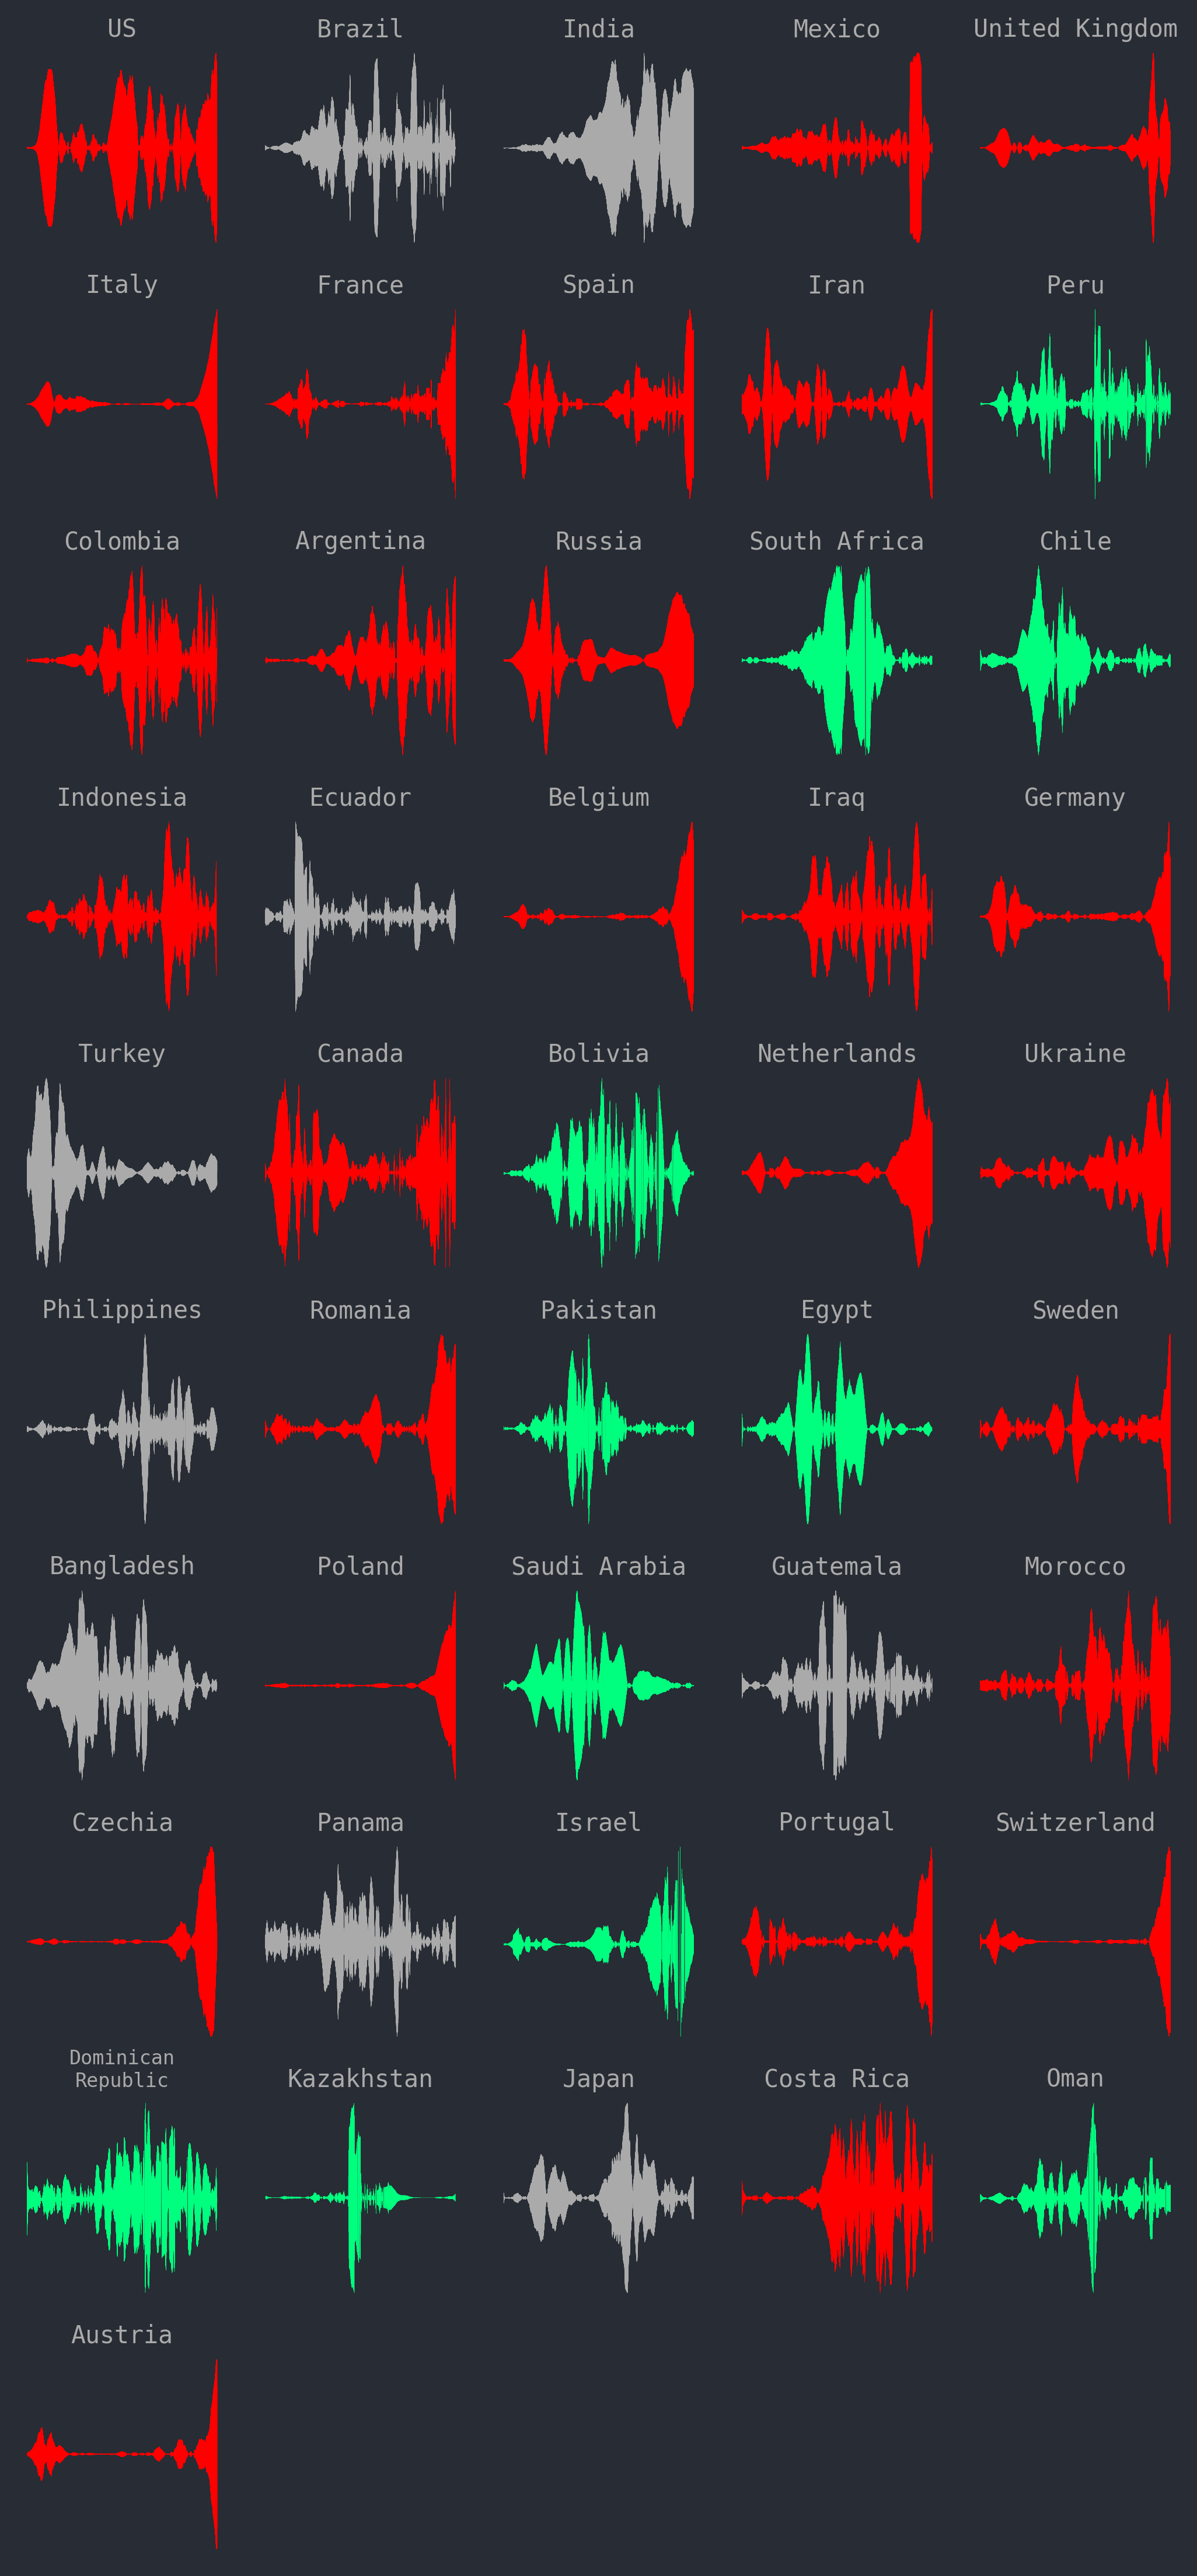

In [16]:
#hide_input
dff2 = cd.get_df(MIN_CASES = 100000, SINCE_CASES = 100)
countries = cd.get_countries_with_min_cases(dff2, 'deaths', min_cases= 1000)
waveforms = make_plot(dff2, countries)

In [17]:
#hide
import wave
# save all sounds as wavs
for waveform, country in zip(waveforms, countries):
    WAVE_OUTPUT_FILENAME = f"data/covid_mp3/{country}.wav"
    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(1) # I guess this is mono
    wf.setsampwidth(4) # from 4 == pyaudio.PyAudio().get_sample_size(pyaudio.paFloat32)
    wf.setframerate(BITRATE)
    #wf.writeframes(waveform)
    wf.writeframes(b''.join(waveform))
    wf.close()

In [119]:
#hide
# get list of all wavs
import glob
import os
wavs = glob.glob("data/covid_mp3/*.wav")

# convert to mp3
import pydub
for wav in wavs:
    name = wav.split("/")[-1].split(".wav")[0]
    print(name)
    sound = pydub.AudioSegment.from_wav(wav)
    sound.export(f"data/covid_mp3/{name}.mp3", format="mp3")
    os.remove(wav)

Brazil
Sweden
Belgium
Czechia
Turkey
Oman
Panama
Switzerland
Ecuador
Iran
Saudi Arabia
Poland
Kazakhstan
Argentina
Colombia
Russia
Guatemala
Bolivia
US
Ukraine
Netherlands
Iraq
Philippines
India
Peru
Italy
Romania
Indonesia
Chile
Mexico
Morocco
Egypt
Dominican Republic
Germany
United Kingdom
Pakistan
Canada
Bangladesh
South Africa
France
Portugal
Spain
Costa Rica
Israel


# Sonified output

Please dial down the volume. The following is not exactly nice to listen to:

In [58]:
#hide_input
from IPython.display import display, Markdown, Latex
for country in countries:
    display(Markdown(f'<h4>{country}</h4>'))
    display(Markdown(f'<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/{country}.mp3</p>'))

<h4>US</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/US.mp3</p>

<h4>Brazil</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Brazil.mp3</p>

<h4>India</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/India.mp3</p>

<h4>Mexico</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Mexico.mp3</p>

<h4>United Kingdom</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/United Kingdom.mp3</p>

<h4>Italy</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Italy.mp3</p>

<h4>France</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/France.mp3</p>

<h4>Spain</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Spain.mp3</p>

<h4>Peru</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Peru.mp3</p>

<h4>Iran</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Iran.mp3</p>

<h4>Colombia</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Colombia.mp3</p>

<h4>Argentina</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Argentina.mp3</p>

<h4>Russia</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Russia.mp3</p>

<h4>South Africa</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/South Africa.mp3</p>

<h4>Chile</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Chile.mp3</p>

<h4>Indonesia</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Indonesia.mp3</p>

<h4>Ecuador</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Ecuador.mp3</p>

<h4>Belgium</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Belgium.mp3</p>

<h4>Iraq</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Iraq.mp3</p>

<h4>Germany</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Germany.mp3</p>

<h4>Canada</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Canada.mp3</p>

<h4>Turkey</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Turkey.mp3</p>

<h4>Bolivia</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Bolivia.mp3</p>

<h4>Netherlands</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Netherlands.mp3</p>

<h4>Philippines</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Philippines.mp3</p>

<h4>Ukraine</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Ukraine.mp3</p>

<h4>Pakistan</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Pakistan.mp3</p>

<h4>Romania</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Romania.mp3</p>

<h4>Egypt</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Egypt.mp3</p>

<h4>Sweden</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Sweden.mp3</p>

<h4>Bangladesh</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Bangladesh.mp3</p>

<h4>Saudi Arabia</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Saudi Arabia.mp3</p>

<h4>Poland</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Poland.mp3</p>

<h4>Guatemala</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Guatemala.mp3</p>

<h4>Morocco</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Morocco.mp3</p>

<h4>Czechia</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Czechia.mp3</p>

<h4>Panama</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Panama.mp3</p>

<h4>Israel</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Israel.mp3</p>

<h4>Portugal</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Portugal.mp3</p>

<h4>Dominican Republic</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Dominican Republic.mp3</p>

<h4>Switzerland</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Switzerland.mp3</p>

<h4>Kazakhstan</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Kazakhstan.mp3</p>

<h4>Costa Rica</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Costa Rica.mp3</p>

<h4>Oman</h4>

<p>https://github.com/caglorithm/notebooks/raw/master/_notebooks/data/covid_mp3/Oman.mp3</p>

In [21]:
#hide
# for waveform, country in zip(waveforms, countries):
#     print(country)
#     play_waveform(waveform)
#     print("wait loop")
#     time.sleep(1)

In [40]:
#hide
# #hide_input
# dff2 = cd.get_df(MIN_CASES = 500, SINCE_CASES = 100)
# countries = cd.get_countries_with_min_cases(dff2, 'deaths', min_cases= 10)
# countries.sort()
# make_plot(dff2, countries, ncols=10, savename='large', show=True, hpad=2)

In [8]:
#hide
#code for generating alternative versions

In [9]:
#hide
# dff2 = cd.get_df(MIN_CASES = 1000, SINCE_CASES = 100)
# countries = cd.get_countries_with_min_cases(dff2, 'deaths', min_cases= 100)
# countries.sort()
# make_plot(dff2, countries, savename='sorted', show=False)

In [10]:
#hide
# dff2 = cd.get_df(MIN_CASES = 1000, SINCE_CASES = 100)
# countries = cd.get_countries_with_min_cases(dff2, 'deaths', min_cases= 100)
# make_plot(dff2, countries, savename='neutral', show=False, colors='muted')

In [11]:
#hide
# dff2 = cd.get_df(MIN_CASES = 500, SINCE_CASES = 100)
# countries = cd.get_countries_with_min_cases(dff2, 'deaths', min_cases= 10)
# countries.sort()
# make_plot(dff2, countries, ncols=10, savename='large-neutral', show=False, colors='muted', hpad=2)